# <center> <b> <font color='blue'> Windowing a dataset </center> </b> </font>

Windowing a dataset is used to convert a time series problem into a supervised learning problem.


Setup

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow

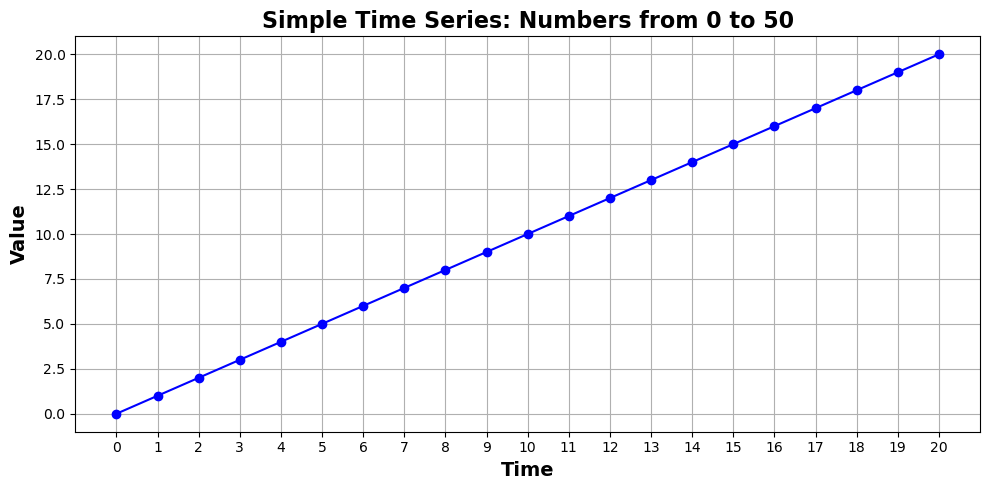

In [18]:


# Create a simple time series dataset: numbers from 0 to 50
series = np.arange(21)  # Generate numbers from 0 to 50
time = np.arange(len(numbers))  # Time index (0 to 50)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(time, series, marker='o', color='blue', linestyle='-')
plt.title('Simple Time Series: Numbers from 0 to 50', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Value', fontsize=14, fontweight='bold')
plt.xticks(time)  # Set x-ticks to be the same as the time values for clarity
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
plt.show()


In [16]:
def windowed_dataset(series, 
                     window_size, 
                     batch_size, 
                     shuffle_buffer=200,
                     shuffle=True):
     
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # drop_remainder -> all of the same size
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1])) #w[:-1] all but the last; w[-1]: the last
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [26]:
window_size = 3

In [19]:
series

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [22]:
ds = tf.data.Dataset.from_tensor_slices(series) # convert to a tensor

In [23]:
type(ds)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [27]:
ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

In [38]:
for window_dataset in ds:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

1 2 3 4 
2 3 4 5 
3 4 5 6 
4 5 6 7 
5 6 7 8 
6 7 8 9 
7 8 9 10 


2024-10-08 20:00:27.895526: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-08 20:00:27.910289: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


In [40]:
#  transform a dataset of windows into a flat dataset of batched tensors
ds = ds.flat_map(lambda w: w.batch(window_size + 1)) #

In [43]:
for window in ds:
    print(window.numpy())

[1 2 3 4]
[2 3 4 5]
[3 4 5 6]
[4 5 6 7]
[5 6 7 8]
[6 7 8 9]
[ 7  8  9 10]


In [45]:
# shuffle
ds = ds.shuffle(10)

for window in ds:
    print(window.numpy())

[2 3 4 5]
[5 6 7 8]
[4 5 6 7]
[6 7 8 9]
[ 7  8  9 10]
[3 4 5 6]
[1 2 3 4]


In [48]:
# Transform the dataset by separating each window into input and output components. 
ds = ds.map(lambda w: (w[:-1], w[-1]))
for x, y in ds:
    print(x.numpy(), y.numpy())

[2 3 4] 5
[6 7 8] 9
[7 8 9] 10
[5 6 7] 8
[1 2 3] 4
[4 5 6] 7
[3 4 5] 6


In [51]:
#  prepare the dataset for efficient training or evaluation by batching the data and 
# optimizing the input pipeline. 
batch_size = 32
ds = ds.batch(batch_size).prefetch(1)
for x,y in ds:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[[3 4 5]
  [6 7 8]
  [1 2 3]
  [5 6 7]
  [4 5 6]
  [7 8 9]
  [2 3 4]]]
y =  [[ 6  9  4  8  7 10  5]]


In [53]:
# we can put everything together in one function
def windowed_dataset(series, 
                     window_size=3, 
                     batch_size=32, 
                     shuffle_buffer=10,
                     shuffle=True):
     
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # drop_remainder -> all of the same size
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1])) #w[:-1] all but the last; w[-1]: the last
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [54]:
ds2 = windowed_dataset(series)

In [55]:
for x,y in ds2:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[1 2 3]
 [4 5 6]
 [6 7 8]
 [7 8 9]
 [3 4 5]
 [2 3 4]
 [5 6 7]]
y =  [ 4  7  9 10  6  5  8]


Until now, we have been making predictions only one step ahead into the future. Let's see how to modify the previous code to make predictions several steps ahead.

### Several steps ahead

In [72]:
import numpy as np
import tensorflow as tf

# Generate a varied multivariate time series dataset
def generate_varied_data(num_samples):
    # Create time steps
    time_steps = np.arange(num_samples)
    
    # Generate random data for temperature, humidity, and pressure
    np.random.seed(0)  # For reproducibility
    temperature = np.random.randint(20, 31, size=num_samples)  # Values between 20 and 30
    humidity = np.random.uniform(70, 85, size=num_samples)  # Values between 0.70 and 0.85
    pressure = np.random.randint(99, 101, size=num_samples)  # Values between 990 and 1010
    
    # Stack features together
    data = np.column_stack((time_steps, temperature, humidity, pressure))
    return data

# Generate 10 samples of data
data = generate_varied_data(num_samples=10)



# Print each row with formatted values
print("Sample dataset with 2 significant digits:")
for row in data:
    formatted_row = [f"{value:.3g}" for value in row]  # Format each value to 2 significant digits
    print(formatted_row)



Sample dataset with 2 significant digits:
['0', '25', '74.5', '99']
['1', '20', '70.9', '100']
['2', '23', '74.1', '100']
['3', '23', '77.2', '99']
['4', '27', '82.2', '100']
['5', '29', '77.2', '100']
['6', '23', '75.9', '99']
['7', '25', '82.5', '99']
['8', '22', '75.1', '100']
['9', '24', '79.7', '99']


We will try to predict "pressure".

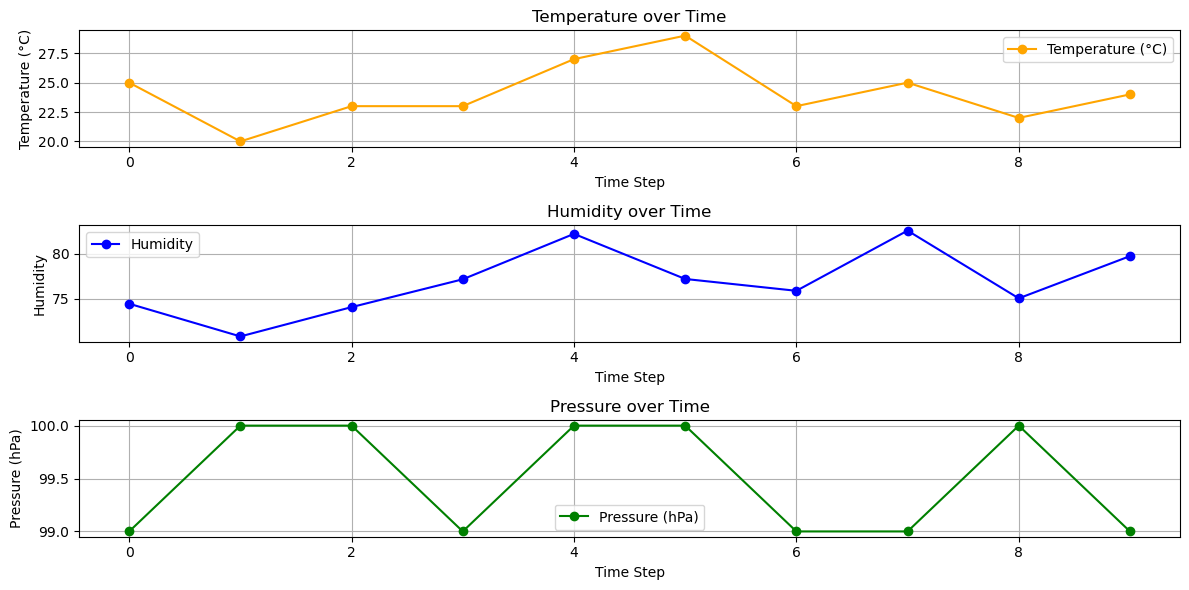

In [65]:
import numpy as np
import matplotlib.pyplot as plt


"""
# Sample raw data
data = np.array([[0, 20.1, 0.8, 1000],    # Time step, Temperature, Humidity, Pressure
                 [1, 25.5, 0.76, 995],
                 [2, 30.3, 0.83, 1005],
                 [3, 28.0, 0.75, 1002],
                 [4, 22.5, 0.78, 1003]])
"""

# Extracting time steps, temperature, humidity, and pressure
time_steps = data[:, 0]
temperature = data[:, 1]
humidity = data[:, 2]
pressure = data[:, 3]

# Creating the plots
plt.figure(figsize=(12, 6))

# Plot temperature
plt.subplot(3, 1, 1)
plt.plot(time_steps, temperature, marker='o', color='orange', label='Temperature (°C)')
plt.title('Temperature over Time')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.legend()

# Plot humidity
plt.subplot(3, 1, 2)
plt.plot(time_steps, humidity, marker='o', color='blue', label='Humidity')
plt.title('Humidity over Time')
plt.xlabel('Time Step')
plt.ylabel('Humidity')
plt.grid()
plt.legend()

# Plot pressure
plt.subplot(3, 1, 3)
plt.plot(time_steps, pressure, marker='o', color='green', label='Pressure (hPa)')
plt.title('Pressure over Time')
plt.xlabel('Time Step')
plt.ylabel('Pressure (hPa)')
plt.grid()
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


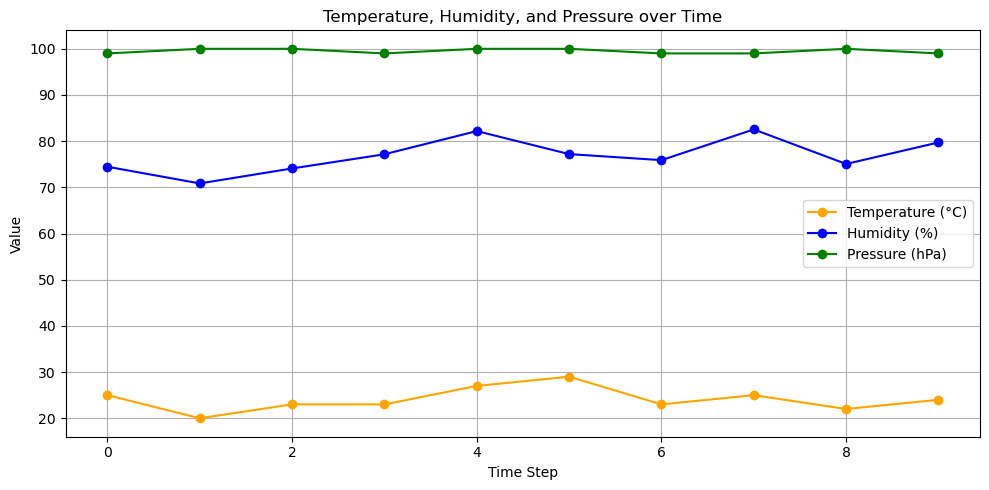

In [66]:
import numpy as np
import matplotlib.pyplot as plt

"""
# Sample raw data
data = np.array([[0, 20.1, 0.8, 1000],    # Time step, Temperature, Humidity, Pressure
                 [1, 25.5, 0.76, 995],
                 [2, 30.3, 0.83, 1005],
                 [3, 28.0, 0.75, 1002],
                 [4, 22.5, 0.78, 1003]])
"""

# Extracting time steps, temperature, humidity, and pressure
time_steps = data[:, 0]
temperature = data[:, 1]
humidity = data[:, 2] #* 100  # Scale humidity for better visibility
pressure = data[:, 3] #/ 10    # Scale pressure for better visibility

# Creating the plot
plt.figure(figsize=(10, 5))

# Plot temperature
plt.plot(time_steps, temperature, marker='o', color='orange', label='Temperature (°C)')

# Plot humidity (scaled)
plt.plot(time_steps, humidity, marker='o', color='blue', label='Humidity (%)')

# Plot pressure (scaled)
plt.plot(time_steps, pressure, marker='o', color='green', label='Pressure (hPa)')

# Add title and labels
plt.title('Temperature, Humidity, and Pressure over Time')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid()

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


First steps are the same as before.

In [67]:
data

array([[  0.        ,  25.        ,  74.4630191 ,  99.        ],
       [  1.        ,  20.        ,  70.85069466, 100.        ],
       [  2.        ,  23.        ,  74.08984442, 100.        ],
       [  3.        ,  23.        ,  77.16497676,  99.        ],
       [  4.        ,  27.        ,  82.18253093, 100.        ],
       [  5.        ,  29.        ,  77.19965759, 100.        ],
       [  6.        ,  23.        ,  75.89177194,  99.        ],
       [  7.        ,  25.        ,  82.54118145,  99.        ],
       [  8.        ,  22.        ,  75.06094241, 100.        ],
       [  9.        ,  24.        ,  79.72257808,  99.        ]])

In [56]:
# Modify the windowed dataset creation to separate the target (temperature) from the features
def windowed_dataset(data, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Create sliding windows of size window_size + 1 (for the label)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset and create feature/label pairs
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Features are all columns except the last temperature column at time t+1
    # Target is the temperature at time t+1 (index 0 because temperature is the first column in filtered data)
    dataset = dataset.map(lambda window: (window[:-1, 1:], window[-1][0]))  # Only take 'T' as target
                # before it was just window[-1] but I only want to predict temperature
                # similar for the features
    
    # Shuffle, batch, and prefetch
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [74]:
data = np.array([[0, 20, 8, 1000],    # Time step, Temperature, Humidity, Pressure
                 [1, 25, 76, 995],
                 [2, 30, 83, 1005],
                 [3, 28, 75, 1002],
                 [4, 22, 78, 1003]])

In [99]:
data = np.array([[0, 20, 8],    # Time step, Temperature, Humidity, Pressure
                 [1, 25, 76],
                 [2, 30, 83],
                 [3, 28, 75],
                 [4, 22, 78]])

In [100]:
window_size = 2

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

[ 0 20  8] [ 1 25 76] [ 2 30 83] 
[ 1 25 76] [ 2 30 83] [ 3 28 75] 
[ 2 30 83] [ 3 28 75] [ 4 22 78] 


2024-10-08 20:52:17.498541: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [101]:
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
for window in dataset:
    print(window.numpy())

[[ 0 20  8]
 [ 1 25 76]
 [ 2 30 83]]
[[ 1 25 76]
 [ 2 30 83]
 [ 3 28 75]]
[[ 2 30 83]
 [ 3 28 75]
 [ 4 22 78]]


In [102]:
dataset = dataset.map(lambda window: (window[:-1, 1:], window[-1][0])) 

In [103]:
for x,y in dataset:
    print(x.numpy(), y.numpy())

[[20  8]
 [25 76]] 2
[[25 76]
 [30 83]] 3
[[30 83]
 [28 75]] 4


In [106]:
data[:-1, 1:]

array([[20,  8],
       [25, 76],
       [30, 83],
       [28, 75]])

In [107]:
data[-1][0]

4

In [108]:
import tensorflow as tf
import numpy as np

def windowed_multivariate_dataset(series, window_size, batch_size, shuffle_buffer=200, shuffle=True):
    """
    Creates a windowed dataset for multivariate time series forecasting.
    
    Parameters:
    - series (np.array): Multivariate time series data (including multiple features such as births, deceases, etc.).
    - window_size (int): Number of time steps in each window.
    - batch_size (int): Batch size for training.
    - shuffle_buffer (int): Buffer size for shuffling the dataset.
    - shuffle (bool): Whether to shuffle the dataset or not.
    
    Returns:
    - tf.data.Dataset: A TensorFlow dataset with input-output pairs for training.
    """
    # Convert the NumPy array to a TensorFlow Dataset
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create a sliding window with window_size + 1 elements (the extra one is the target)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Convert the windows to batches of size window_size + 1
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    
    # Optionally shuffle the dataset
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Separate the input (all features except the last time step) and the target (deceases)
    ds = ds.map(lambda w: (w[:-1, 1:], w[-1, 2]))  # w[:-1, 1:] -> all but the last time step for features (exclude time)
                                                  # w[-1, 2] -> the deceases value for the target
    
    # Batch the dataset and prefetch to improve performance
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

# Sample data: Time, Births, Deceases
data = np.array([[0, 20, 8],
                 [1, 25, 76],
                 [2, 30, 83],
                 [3, 28, 75],
                 [4, 22, 78]])

# Hyperparameters
window_size = 2
batch_size = 2
shuffle_buffer = 100

# Create the windowed multivariate dataset
dataset = windowed_multivariate_dataset(data, window_size, batch_size, shuffle_buffer)

# Check the batches
for x, y in dataset:
    print("Input (features):")
    print(x.numpy())
    print("Target (deceases):")
    print(y.numpy())
    print("\n")


Input (features):
[[[25 76]
  [30 83]]

 [[30 83]
  [28 75]]]
Target (deceases):
[75 78]


Input (features):
[[[20  8]
  [25 76]]]
Target (deceases):
[83]




I use the past data points [20, 8] and [25, 76] (representing births and deceases at two previous time steps) to predict the deceases value of 83 at the next time step.